### Import libraries

In [59]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import pickle
import joblib

import os

### Helper functions

In [2]:
def plot_on_lift_or_not_on_lift(df, plot_title='On lift vs. not on lift'):
    """
    Plot altitude over time, colored by 'on_lift' status.
    Will not plot if 'Timestamp' column is in wrong format.

    Parameters:
        df (DataFrame): DataFrame containing 'Timestamp' and 'Alt(m)' columns.
        plot_title (str, optional): Title of the plot (default is 'On lift vs. not on lift').

    This function creates a scatter plot to visualize the altitude changes over time.
    Altitude data is color-coded based on the 'on_lift' status: 'On the lift' (in red) and 'Not on the lift' (in blue).
    Customize line thickness and marker size as needed.
    """

    # Check if 'Timestamp' column exists and is in datetime format
    if 'Timestamp' in df.columns and pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
        # Plot for Altitude over Time, colored by 'on_lift' status
        plt.figure(figsize=(15, 5))

        # Plot points where 'on_lift' is 1 with one color
        plt.scatter(df.loc[df['on_lift'] == 1, 'Timestamp'],
                    df.loc[df['on_lift'] == 1, 'Alt(m)'],
                    c='red',
                    label='On the lift',
                    marker='o',
                    linewidths=3,
                    s=2
                   )

        # Plot points where 'on_lift' is 0 with another color
        plt.scatter(df.loc[df['on_lift'] == 0, 'Timestamp'],
                    df.loc[df['on_lift'] == 0, 'Alt(m)'],
                    c='blue',
                    label='Not on the lift',
                    marker='o',
                    linewidths=3,
                    s=2)

        plt.title(plot_title)
        plt.xlabel('Timestamp')
        plt.ylabel('Altitude (m)')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Warning: DataFrame's 'Timestamp' column is not in datetime format and must be converted first.")


In [3]:
def plot_lift_rides(df, plot_title='Tracked data'):

    # Create a line plot using Plotly
    fig = go.Figure()
    
    # Add a trace for altitude over time
    fig.add_trace(go.Scatter(x=df['Timestamp'], y=df['Alt(m)'], mode='lines', name='Altitude'))
    
    # Update layout
    fig.update_layout(title=plot_title,
                      xaxis_title='Timestamp',
                      yaxis_title='Altitude (m)')
    
    # Show plot
    fig.show()

In [4]:
def check_predictions(df, plot_title='Predictions'):
    # Check if 'Timestamp' column exists and is in datetime format
    if 'Timestamp' in df.columns and pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
        # Create a scatter plot for Altitude over Time, colored by 'predicted' class
        fig = px.scatter(df, x='Timestamp', y='Alt(m)', color='predicted',
                         labels={'Alt(m)': 'Altitude (m)'},
                         title=plot_title,
                         color_discrete_map={0: 'blue', 1: 'red'})

        fig.update_traces(marker=dict(size=8),
                          selector=dict(mode='markers'))

        # Customize the legend
        fig.update_layout(
            legend_title_text='Status',
            width=2000,
            height=900
        )

        fig.for_each_trace(lambda trace: trace.update(name='Not on the lift' if trace.name == 0 else 'On the lift'))

        # Show the plot
        fig.show()
    else:
        print("Warning: DataFrame's 'Timestamp' column is not in datetime format and must be converted first.")

### Import data

In [5]:
#Kate's raw data 
Andermatt_Gutsch_file='/Users/ze/Documents/Coding/Projects/alturos/data/raw/Andermatt_Gondelbahn_Gutsch-2024-02-04_11-58-32.csv'
Natschen_46_file='/Users/ze/Documents/Coding/Projects/alturos/data/raw/Natschen-2024-02-04_12-01-46.csv'
Natschen_18_file='/Users/ze/Documents/Coding/Projects/alturos/data/raw/Natschen-2024-02-04_12-04-18.csv'

In [6]:
#csv to df 
df_Andermatt_Gutsch=pd.read_csv(Andermatt_Gutsch_file)
df_Natschen_46=pd.read_csv(Natschen_46_file)
df_Natschen_18=pd.read_csv(Natschen_18_file)

# Data Exploration

In [7]:
print(df_Andermatt_Gutsch.shape)
print(df_Natschen_46.shape)
print(df_Natschen_18.shape)

(11121, 32)
(11337, 32)
(13268, 32)


In [8]:
# Convert to datetime format 
df_Andermatt_Gutsch['Timestamp'] = pd.to_datetime(df_Andermatt_Gutsch['Timestamp'], unit='ns')
df_Natschen_46['Timestamp'] = pd.to_datetime(df_Natschen_46['Timestamp'], unit='ns')
df_Natschen_18['Timestamp'] = pd.to_datetime(df_Natschen_18['Timestamp'], unit='ns')

In [9]:
df_lst=[df_Andermatt_Gutsch,df_Natschen_18,df_Natschen_46]

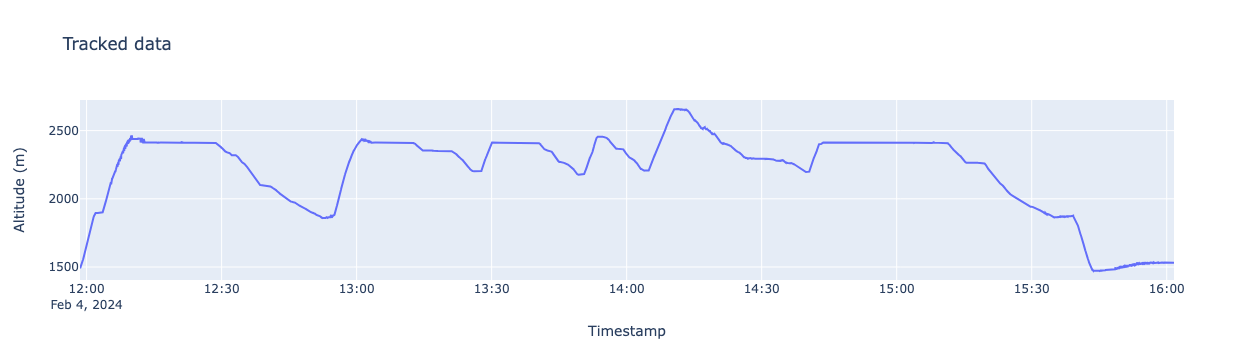

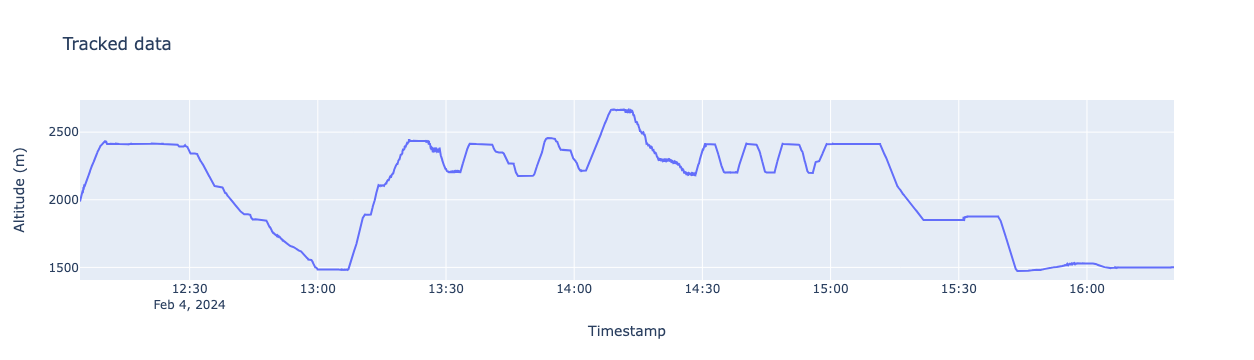

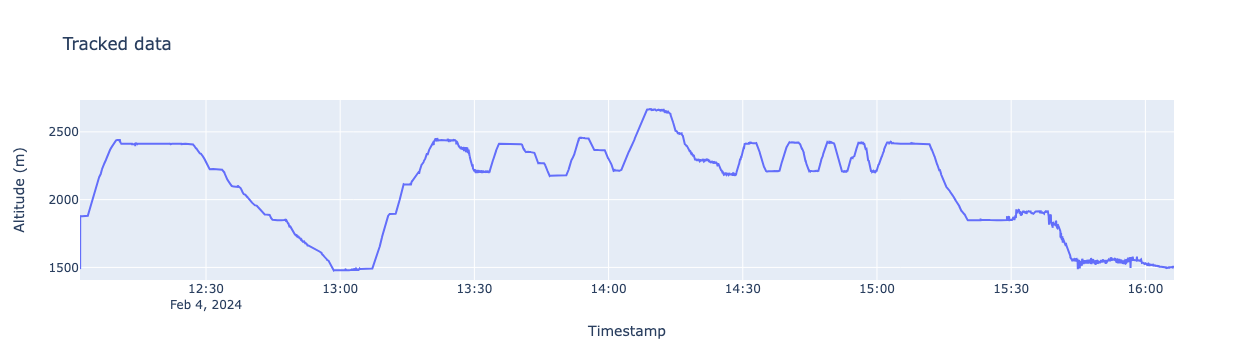

In [10]:
# plotting 
for df in df_lst:
    plot_lift_rides(df)

In [11]:
df_Andermatt_Gutsch.columns

Index(['Timestamp', 'gyroZ(rad/s)', 'gyroY(rad/s)', 'gyroX(rad/s)',
       'accelUserZ(g)', 'accelUserY(g)', 'accelUserX(g)',
       'RelativeAltitude(meters)', 'Pressure(kilopascals)', 'accelZ(g)',
       'accelY(g)', 'accelX(g)', 'VerticalAccuracy(m)',
       'HorizontalAccuracy(m)', 'Speed(m/s)', 'Course', 'Alt(m)', 'Long',
       'Lat', 'calMagZ(µT)', 'calMagY(µT)', 'calMagX(µT)', 'magZ(µT)',
       'magY(µT)', 'magX(µT)', 'qZ', 'qY', 'qX', 'qW', 'Roll(rads)',
       'Pitch(rads)', 'Yaw(rads)'],
      dtype='object')

In [12]:
# Index(['Timestamp', 'accelX(g)', 'accelY(g)', 'accelZ(g)', 'accelUserX(g)',
#        'accelUserY(g)', 'accelUserZ(g)', 'gyroX(rad/s)', 'gyroY(rad/s)',
#        'gyroZ(rad/s)', 'Roll(rads)', 'Pitch(rads)', 'Yaw(rads)', 'm11', 'm12',
#        'm13', 'm21', 'm22', 'm23', 'm31', 'm32', 'm33', 'qX', 'qY', 'qZ', 'qW',
#        'Lat', 'Long', 'Speed(m/s)', 'TrueHeading', 'Alt(m)',
#        'HorizontalAccuracy(m)', 'VerticalAccuracy(m)', 'Course',
#        'ActivityType', 'ActivityConfidence', 'Pressure(kilopascals)',
#        'RelativeAltitude(meters)', 'magX(µT)', 'magY(µT)', 'magZ(µT)',
#        'calMagX(µT)', 'calMagY(µT)', 'calMagZ(µT)', 'on_lift'],
#       dtype='object')

In [13]:
# 0   accelX(g)              24078 non-null  float64
#  1   accelY(g)              24078 non-null  float64
#  2   accelZ(g)              24078 non-null  float64
#  3   accelUserX(g)          24078 non-null  float64
#  4   accelUserY(g)          24078 non-null  float64
#  5   accelUserZ(g)          24078 non-null  float64
#  6   gyroX(rad/s)           24078 non-null  float64
#  7   gyroY(rad/s)           24078 non-null  float64
#  8   gyroZ(rad/s)           24078 non-null  float64
#  9   Roll(rads)             24078 non-null  float64
#  10  Pitch(rads)            24078 non-null  float64
#  11  Yaw(rads)              24078 non-null  float64
#  12  Lat                    24078 non-null  float64
#  13  Long                   24078 non-null  float64
#  14  Speed(m/s)             24078 non-null  float64
#  15  HorizontalAccuracy(m)  24078 non-null  float64
#  16  VerticalAccuracy(m)    24078 non-null  float64
#  17  Course                 24078 non-null  float64
#  18  calMagX(µT)            24078 non-null  float64
#  19  calMagY(µT)            24078 non-null  float64
#  20  calMagZ(µT)            24078 non-null  float64
#  21  on_lift                24078 non-null  int64  
#  22  Alt(m)_change          24078 non-null  float64
#  23  Speed(m/s)_change      24078 non-null  float64
#  24  Course_change          24078 non-null  float64

# feature engineering with outlier removal

In [14]:
# df_Andermatt_Gutsch=pd.read_csv(Andermatt_Gutsch_file)
# df_Natschen_46=pd.read_csv(Natschen_46_file)
# df_Natschen_18=pd.read_csv(Natschen_18_file)

### Altitude Change

(11121, 33)
(11101, 33)


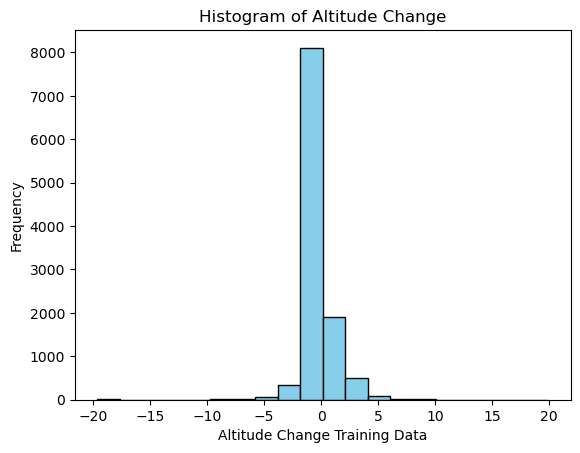

In [15]:
# Add Altitude Change for df_Andermatt_Gutsch 
df_Andermatt_Gutsch['Alt(m)_change'] = df_Andermatt_Gutsch['Alt(m)'].diff().fillna(0)
print(df_Andermatt_Gutsch.shape)

# Set the threshold value for filtering
threshold = 20

# Filter the DataFrame based on the absolute value of 'Alt(m)_change' column
df_Andermatt_Gutsch = df_Andermatt_Gutsch[df_Andermatt_Gutsch['Alt(m)_change'].abs() <= threshold]


# Verify 
print(df_Andermatt_Gutsch.shape)

# Create a histogram plot
plt.hist(df_Andermatt_Gutsch['Alt(m)_change'], 
         bins=20, 
         color='skyblue', 
         edgecolor='black')

#Add labels and title
plt.xlabel('Altitude Change Training Data')
plt.ylabel('Frequency')
plt.title('Histogram of Altitude Change')

#Show the plot
plt.show()

(11337, 33)
(11260, 33)


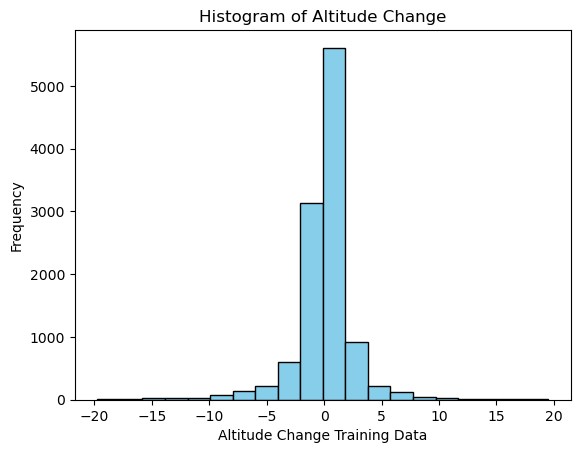

In [16]:
# Add Altitude Change for df_Natschen_46 
df_Natschen_46['Alt(m)_change'] = df_Natschen_46['Alt(m)'].diff().fillna(0)
print(df_Natschen_46.shape)

# Set the threshold value for filtering
threshold = 20

# Filter the DataFrame based on the absolute value of 'Alt(m)_change' column
df_Natschen_46 = df_Natschen_46[df_Natschen_46['Alt(m)_change'].abs() <= threshold]


# Verify 
print(df_Natschen_46.shape)

# Create a histogram plot
plt.hist(df_Natschen_46['Alt(m)_change'], 
         bins=20, 
         color='skyblue', 
         edgecolor='black')

#Add labels and title
plt.xlabel('Altitude Change Training Data')
plt.ylabel('Frequency')
plt.title('Histogram of Altitude Change')

#Show the plot
plt.show()

(13268, 33)
(13252, 33)


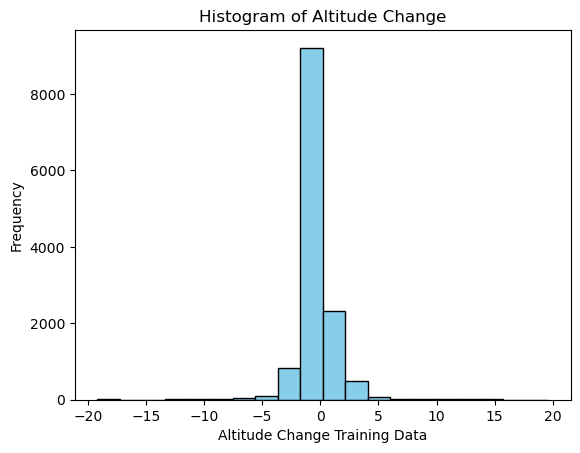

In [17]:
# Add Altitude Change for df_Natschen_18 
df_Natschen_18['Alt(m)_change'] = df_Natschen_18['Alt(m)'].diff().fillna(0)
print(df_Natschen_18.shape)

# Set the threshold value for filtering
threshold = 20

# Filter the DataFrame based on the absolute value of 'Alt(m)_change' column
df_Natschen_18 = df_Natschen_18[df_Natschen_18['Alt(m)_change'].abs() <= threshold]


# Verify 
print(df_Natschen_18.shape)

# Create a histogram plot
plt.hist(df_Natschen_18['Alt(m)_change'], 
         bins=20, 
         color='skyblue', 
         edgecolor='black')

#Add labels and title
plt.xlabel('Altitude Change Training Data')
plt.ylabel('Frequency')
plt.title('Histogram of Altitude Change')

#Show the plot
plt.show()

### Speed Change

/var/folders/kw/4f743mkj0mzb2f42sdfvy9jw0000gn/T/ipykernel_51208/1211029107.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(11101, 34)
(11101, 34)


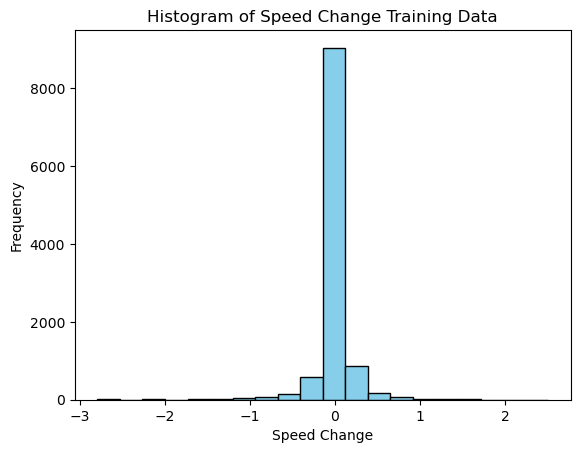

In [18]:
# Add Speed Change for df_Andermatt_Gutsch
df_Andermatt_Gutsch['Speed(m/s)_change'] = df_Andermatt_Gutsch['Speed(m/s)'].diff().fillna(0)
print(df_Andermatt_Gutsch.shape)

# Set the threshold value for filtering
threshold = 3

# Filter the DataFrame based on the absolute value of 'Speed(m/s)_change' column
df_Andermatt_Gutsch = df_Andermatt_Gutsch[df_Andermatt_Gutsch['Speed(m/s)_change'].abs() <= threshold]

# Verify 
print(df_Andermatt_Gutsch.shape) 

# Create a histogram plot
plt.hist(df_Andermatt_Gutsch['Speed(m/s)_change'], 
         bins=20, 
         color='skyblue', 
         edgecolor='black')

#Add labels and title
plt.xlabel('Speed Change')
plt.ylabel('Frequency')
plt.title('Histogram of Speed Change Training Data')

#Show the plot
plt.show()

/var/folders/kw/4f743mkj0mzb2f42sdfvy9jw0000gn/T/ipykernel_51208/3713635662.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(11260, 34)
(11229, 34)


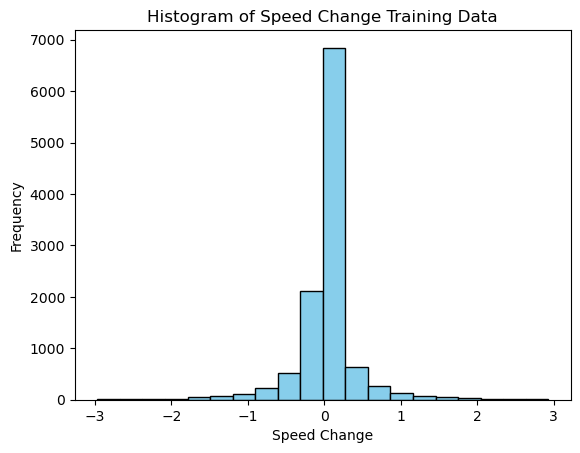

In [19]:
# Add Speed Change df_Natschen_46
df_Natschen_46['Speed(m/s)_change'] = df_Natschen_46['Speed(m/s)'].diff().fillna(0)
print(df_Natschen_46.shape)

# Set the threshold value for filtering
threshold = 3

# Filter the DataFrame based on the absolute value of 'Speed(m/s)_change' column
df_Natschen_46 = df_Natschen_46[df_Natschen_46['Speed(m/s)_change'].abs() <= threshold]

# Verify 
print(df_Natschen_46.shape) 

# Create a histogram plot
plt.hist(df_Natschen_46['Speed(m/s)_change'], 
         bins=20, 
         color='skyblue', 
         edgecolor='black')

#Add labels and title
plt.xlabel('Speed Change')
plt.ylabel('Frequency')
plt.title('Histogram of Speed Change Training Data')

#Show the plot
plt.show()

/var/folders/kw/4f743mkj0mzb2f42sdfvy9jw0000gn/T/ipykernel_51208/321463939.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(13252, 34)
(13231, 34)


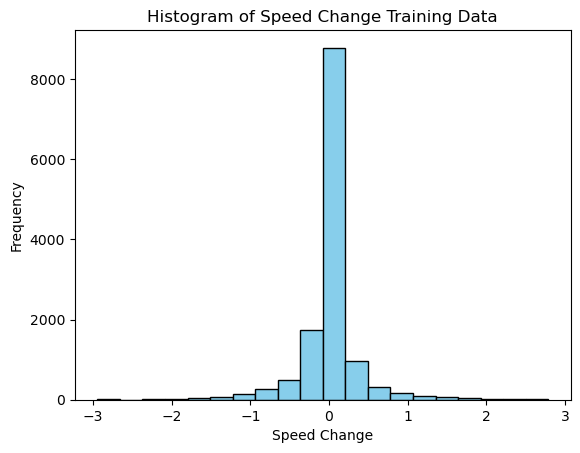

In [20]:
# Add Speed Change df_Natschen_48
df_Natschen_18['Speed(m/s)_change'] = df_Natschen_18['Speed(m/s)'].diff().fillna(0)
print(df_Natschen_18.shape)

# Set the threshold value for filtering
threshold = 3

# Filter the DataFrame based on the absolute value of 'Speed(m/s)_change' column
df_Natschen_18 = df_Natschen_18[df_Natschen_18['Speed(m/s)_change'].abs() <= threshold]

# Verify 
print(df_Natschen_18.shape) 

# Create a histogram plot
plt.hist(df_Natschen_18['Speed(m/s)_change'], 
         bins=20, 
         color='skyblue', 
         edgecolor='black')

#Add labels and title
plt.xlabel('Speed Change')
plt.ylabel('Frequency')
plt.title('Histogram of Speed Change Training Data')

#Show the plot
plt.show()

### Course change

In [22]:
# Add Course Change to df_Andermatt_Gutsch
df_Andermatt_Gutsch['Course_change'] = df_Andermatt_Gutsch['Course'].diff().fillna(0)
# Add Course Change to df_Natschen_18
df_Natschen_18['Course_change'] = df_Natschen_18['Course'].diff().fillna(0)
# Add Course Change to df_Natschen_46
df_Natschen_46['Course_change'] = df_Natschen_46['Course'].diff().fillna(0)

In [23]:
# Verify 
print(df_Andermatt_Gutsch.info())
print(df_Natschen_18.info())
print(df_Natschen_46.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11101 entries, 0 to 11120
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Timestamp                 11101 non-null  datetime64[ns]
 1   gyroZ(rad/s)              11101 non-null  float64       
 2   gyroY(rad/s)              11101 non-null  float64       
 3   gyroX(rad/s)              11101 non-null  float64       
 4   accelUserZ(g)             11101 non-null  float64       
 5   accelUserY(g)             11101 non-null  float64       
 6   accelUserX(g)             11101 non-null  float64       
 7   RelativeAltitude(meters)  11101 non-null  float64       
 8   Pressure(kilopascals)     11101 non-null  float64       
 9   accelZ(g)                 11101 non-null  float64       
 10  accelY(g)                 11101 non-null  float64       
 11  accelX(g)                 11101 non-null  float64       
 12  VerticalAccuracy(m

# Feature Selection

In [52]:
# List of features to drop
usual_features_to_drop = ['Timestamp',
                    'ActivityType', 
                    'ActivityConfidence', 
                    
                    'RelativeAltitude(meters)',
                    'Alt(m)',
            
                    'Pressure(kilopascals)',
                    'TrueHeading',

                    'm11', 'm12','m13', 'm21', 'm22', 'm23', 'm31', 'm32', 'm33',
                    'qX', 'qY', 'qZ', 'qW',

                    'magX(µT)', 'magY(µT)', 'magZ(µT)',
                    
                    ]


features_to_drop_from_kates_data = [

# KeyError: "['ActivityType', 'ActivityConfidence', 'TrueHeading', 'm11', 'm12', 'm13', 'm21', 'm22', 'm23', 'm31', 'm32', 'm33'] not found in axis"
    
                    'Timestamp',
                    # 'ActivityType', 
                    # 'ActivityConfidence', 
                    
                    'RelativeAltitude(meters)',
                    'Alt(m)',
            
                    'Pressure(kilopascals)',
                    # 'TrueHeading',

                    # 'm11', 'm12','m13', 'm21', 'm22', 'm23', 'm31', 'm32', 'm33',
                    'qX', 'qY', 'qZ', 'qW',

                    'magX(µT)', 'magY(µT)', 'magZ(µT)',
                    
                    ]


# helper function
# def drop_features(df,features_to_drop):
    # Drop the specified features from the train DataFrame
df_ready_for_model_input = df_Andermatt_Gutsch.drop(features_to_drop_from_kates_data, axis=1)
    
    # Verify 
    # print(df_ready_for_model_input.info())


    # this function should check that the following features are listed as columns in the data frame 
    # the function should also check for correct spelling 
    # the function should print the name of the features(columns) that are missing, but only of the most important features for prediction 
    
    # return df_ready_for_model_input

# Modelling

In [69]:
df_ready_for_model_input.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11101 entries, 0 to 11120
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gyroZ(rad/s)           11101 non-null  float64
 1   gyroY(rad/s)           11101 non-null  float64
 2   gyroX(rad/s)           11101 non-null  float64
 3   accelUserZ(g)          11101 non-null  float64
 4   accelUserY(g)          11101 non-null  float64
 5   accelUserX(g)          11101 non-null  float64
 6   accelZ(g)              11101 non-null  float64
 7   accelY(g)              11101 non-null  float64
 8   accelX(g)              11101 non-null  float64
 9   VerticalAccuracy(m)    11101 non-null  float64
 10  HorizontalAccuracy(m)  11101 non-null  float64
 11  Speed(m/s)             11101 non-null  float64
 12  Course                 11101 non-null  float64
 13  Long                   11101 non-null  float64
 14  Lat                    11101 non-null  float64
 15  ca

In [73]:
# reorder columns to prepare for model input 

# Define the desired order of column names
desired_order = ['accelX(g)', 'accelY(g)', 'accelZ(g)', 'accelUserX(g)', 'accelUserY(g)',
       'accelUserZ(g)', 'gyroX(rad/s)', 'gyroY(rad/s)', 'gyroZ(rad/s)',
       'Roll(rads)', 'Pitch(rads)', 'Yaw(rads)', 'Lat', 'Long', 'Speed(m/s)',
       'HorizontalAccuracy(m)', 'VerticalAccuracy(m)', 'Course', 'calMagX(µT)',
       'calMagY(µT)', 'calMagZ(µT)', 'Alt(m)_change',
       'Speed(m/s)_change', 'Course_change']

# Reorder the columns based on the desired order
df_ready_for_model_input = df_ready_for_model_input[desired_order]

In [74]:
X = df_ready_for_model_input
X.shape

(11101, 24)

In [75]:
# load model 

# Specify the file path of the pickle file
file_path_to_model = '/Users/ze/Documents/Coding/Projects/alturos/models/rf_v_0.1.pkl'

# # Load the model from the pickle file
# with open(file_path, 'rb') as file:
#     rf_model = pickle.load(file)

In [77]:
# Load the saved model
rfc_model = joblib.load(file_path_to_model)

# show hyperparameters
rfc_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [78]:
# Use the loaded model for predictions
predictions = rfc_model.predict(X)

# Plot predictions

In [80]:
df_with_predictions=df_Andermatt_Gutsch
df_with_predictions['predicted']=predictions
# df_test_concatenated['Timestamp'] = pd.to_datetime(df_test_concatenated['Timestamp'], unit='ns')
df_with_predictions.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11101 entries, 0 to 11120
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Timestamp                 11101 non-null  datetime64[ns]
 1   gyroZ(rad/s)              11101 non-null  float64       
 2   gyroY(rad/s)              11101 non-null  float64       
 3   gyroX(rad/s)              11101 non-null  float64       
 4   accelUserZ(g)             11101 non-null  float64       
 5   accelUserY(g)             11101 non-null  float64       
 6   accelUserX(g)             11101 non-null  float64       
 7   RelativeAltitude(meters)  11101 non-null  float64       
 8   Pressure(kilopascals)     11101 non-null  float64       
 9   accelZ(g)                 11101 non-null  float64       
 10  accelY(g)                 11101 non-null  float64       
 11  accelX(g)                 11101 non-null  float64       
 12  VerticalAccuracy(m

In [82]:
df_Andermatt_Gutsch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11101 entries, 0 to 11120
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Timestamp                 11101 non-null  datetime64[ns]
 1   gyroZ(rad/s)              11101 non-null  float64       
 2   gyroY(rad/s)              11101 non-null  float64       
 3   gyroX(rad/s)              11101 non-null  float64       
 4   accelUserZ(g)             11101 non-null  float64       
 5   accelUserY(g)             11101 non-null  float64       
 6   accelUserX(g)             11101 non-null  float64       
 7   RelativeAltitude(meters)  11101 non-null  float64       
 8   Pressure(kilopascals)     11101 non-null  float64       
 9   accelZ(g)                 11101 non-null  float64       
 10  accelY(g)                 11101 non-null  float64       
 11  accelX(g)                 11101 non-null  float64       
 12  VerticalAccuracy(m

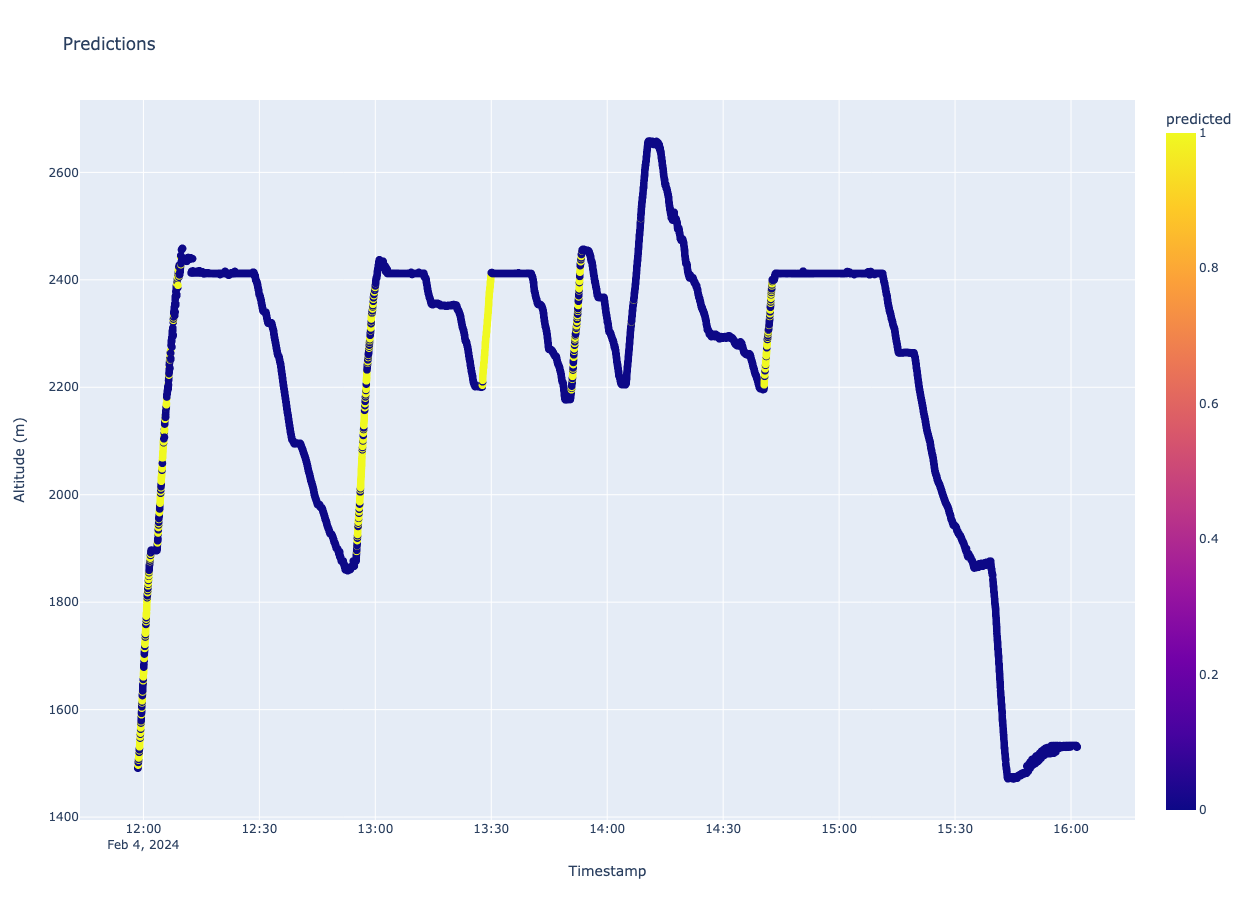

In [83]:
check_predictions(df_with_predictions)